In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from preprocess import *

In [5]:
from sklearn.linear_model import LassoCV, Lasso

In [6]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

In [7]:
# todas as UFs do Nordeste
UFs_NORDESTE = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
UFs_NORDESTE_NAMES = ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Paraíba', 'Pernambuco', 'Piauí', 'Rio Grande do Norte', 'Sergipe']

# Intro

Ingesting some base data

-----------
## Compreender os índices do CRAS

In [8]:
idcras = pd.read_excel(
    '../../dataset/GAMMAChallenge21Dados/6. Assistencia Social/IDCRAS.xlsx',
    sheet_name = 'dados'
)

In [9]:
inspect(idcras);

shape: (64215, 10)
columns: ['ano', 'id_cras', 'cod_ibge', 'uf', 'nome_municipio', 'ind_hora_func', 'ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']


,ano,id_cras,cod_ibge,uf,nome_municipio,ind_hora_func,ind_estru_fisic,ind_servi,ind_rh,id_cras.1
0,2011,11000120396,110001,RO,Alta Floresta D´oeste,4.000,4,4,1,4.000
1,2011,11000206675,110002,RO,Ariquemes,3.000,4,2,1,4.000
2,2011,11000300594,110003,RO,Cabixi,3.000,3,4,3,9.000
3,2011,11000403403,110004,RO,Cacoal,3.000,4,4,2,8.000
4,2011,11000515040,110005,RO,Cerejeiras,3.000,2,4,4,8.000


In [10]:
idcras = generates_normalized_column(idcras, 
                                     column_to_normalize='nome_municipio', 
                                     column_normalized='nome_municipio_norm')

In [11]:
idcras = keep_last_date(idcras, column_dates='ano')

In [12]:
columns_to_keep = ['uf', 'nome_municipio', 'nome_municipio_norm', 'cod_ibge', 'ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']

In [13]:
idcras = idcras[columns_to_keep]

In [14]:
# há cidades com mais de um nucleo CRAS
idcras = (idcras[idcras['uf'].isin(UFs_NORDESTE)]
          .groupby(['uf', 'nome_municipio', 'nome_municipio_norm', 'cod_ibge'])[
              ['ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']
          ]
          .mean())

Como são os índices médios das unidades públicas CRAS para estados e municipios?

In [15]:
idcras_cities = (
    idcras.groupby(['nome_municipio', 
                     'nome_municipio_norm', 
                     'cod_ibge'])[['ind_estru_fisic', 
                                   'ind_servi', 'ind_rh', 
                                   'id_cras.1']]
    .mean()
    .reset_index()
)

inspect(idcras_cities);

shape: (1793, 7)
columns: ['nome_municipio', 'nome_municipio_norm', 'cod_ibge', 'ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']


,nome_municipio,nome_municipio_norm,cod_ibge,ind_estru_fisic,ind_servi,ind_rh,id_cras.1
0,Abaiara,ABAIARA,230010,4.000,3.500,4.500,4.000
1,Abaré,ABARE,290020,2.000,4.000,5.000,3.667
2,Abaíra,ABAIRA,290010,1.000,5.000,4.000,3.333
3,Abreu e Lima,ABREU E LIMA,260005,4.000,3.000,4.000,3.667
4,Acajutiba,ACAJUTIBA,290030,4.000,4.000,5.000,4.333


In [16]:
idcras_states = (
    idcras.groupby(['uf'])[['ind_estru_fisic', 
                             'ind_servi', 
                             'ind_rh', 
                             'id_cras.1']]
    .mean()
    .sort_values('uf')
    .reset_index()
)

inspect(idcras_states);

shape: (9, 5)
columns: ['uf', 'ind_estru_fisic', 'ind_servi', 'ind_rh', 'id_cras.1']


,uf,ind_estru_fisic,ind_servi,ind_rh,id_cras.1
0,AL,3.150,2.322,4.471,3.315
1,BA,3.504,3.122,4.172,3.599
2,CE,3.807,3.364,4.415,3.862
3,MA,3.474,3.394,3.907,3.592
4,PB,3.469,3.137,4.322,3.642


-----------
### Registros CRAS RMA

In [17]:
cras_rma = pd.read_excel(
    '../../dataset/GAMMAChallenge21Dados/6. Assistencia Social/RMA.xlsx',
    sheet_name = 'dados_CRAS'
)

In [18]:
cras_rma = generates_normalized_column(cras_rma, 
                                     column_to_normalize='nome_municipio', 
                                     column_normalized='nome_municipio_norm')

In [19]:
cras_rma = keep_last_date(cras_rma, column_dates='ano')

In [20]:
inspect(cras_rma);

shape: (93517, 32)
columns: ['ano', 'mes_referencia', 'regiao', 'uf', 'cod_ibge', 'nome_municipio', 'porte_municipio', 'nome_unidade', 'numero_cras', 'endereco_cras', 'a1', 'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'nome_municipio_norm']


,ano,mes_referencia,regiao,uf,cod_ibge,nome_municipio,porte_municipio,nome_unidade,numero_cras,endereco_cras,a1,a2,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,d7,nome_municipio_norm
359209,2016,2016-03-01 00:00:00,região norte,RO,110001,Alta Floresta D´oeste,PEQUENO II,'CRAS CENTRO DE REFERENCIA DE ASSISTENCIA SOCIAL',11000120396,'RUA MARANHAO 3300 - PRINCESA ISABEL',0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,485.000,0.000,190.000,2.000,0.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,ALTA FLORESTA D OESTE
359210,2016,2016-04-01 00:00:00,região norte,RO,110001,Alta Floresta D´oeste,PEQUENO II,'CRAS CENTRO DE REFERENCIA DE ASSISTENCIA SOCIAL',11000120396,'RUA MARANHAO 3300 - PRINCESA ISABEL',0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,662.000,2.000,166.000,2.000,0.000,80.000,NaN,5.000,80.000,1.000,60.000,30.000,1.000,ALTA FLORESTA D OESTE
359211,2016,2016-05-01 00:00:00,região norte,RO,110001,Alta Floresta D´oeste,PEQUENO II,'CRAS CENTRO DE REFERENCIA DE ASSISTENCIA SOCIAL',11000120396,'RUA MARANHAO 3300 - PRINCESA ISABEL',2.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,570.000,20.000,77.000,7.000,0.000,23.000,NaN,5.000,80.000,3.000,60.000,33.000,1.000,ALTA FLORESTA D OESTE
359212,2016,2016-06-01 00:00:00,região norte,RO,110001,Alta Floresta D´oeste,PEQUENO II,'CRAS CENTRO DE REFERENCIA DE ASSISTENCIA SOCIAL',11000120396,'RUA MARANHAO 3300 - PRINCESA ISABEL',24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,380.000,2.000,206.000,14.000,0.000,45.000,NaN,7.000,80.000,2.000,60.000,30.000,1.000,ALTA FLORESTA D OESTE
359213,2016,2016-07-01 00:00:00,região norte,RO,110001,Alta Floresta D´oeste,PEQUENO II,'CRAS CENTRO DE REFERENCIA DE ASSISTENCIA SOCIAL',11000120396,'RUA MARANHAO 3300 - PRINCESA ISABEL',24.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,423.000,5.000,142.000,15.000,0.000,37.000,NaN,4.000,80.000,2.000,60.000,30.000,1.000,ALTA FLORESTA D OESTE


In [21]:
cras_rma_states = cras_rma[cras_rma['uf'].isin(UFs_NORDESTE)]
cras_rma_states_grouped = (
    cras_rma_states
    .groupby(['uf', 'nome_municipio_norm'])
    [['cod_ibge', 'a1', 'a2', 'b1', 'b2', 'b3', 'b5', 'b6', 'c1', 'c6', 'd1', 'd4']]
    .mean()
    .fillna(0)
    .astype(int)
)

In [22]:
registry_cras_rma_states_grouped = (
    cras_rma_states_grouped.groupby(['uf'])[['a1', 'a2', 'b1', 'b2', 'b3', 'b5', 'b6', 'c1', 'c6', 'd1', 'd4']]
    .mean()
    .sort_values('uf')
)

In [23]:
registry_cras_rma_states_grouped = (
    registry_cras_rma_states_grouped
    .rename(columns = {
        'a1': 'a1 Total de famílias em acompanhamento pelo PAIF', 
        'a2': 'a2 Novas famílias inseridas no acompanhamento do PAIF no mês de referência',
        'b1': 'b1 PAIF Famílias em situação de extrema pobreza',
        'b2': 'b2 PAIF Famílias beneficiárias do Programa Bolsa Família',
        'b3': 'b3 PAIF Famílias beneficiárias do Programa Bolsa Família, em descumprimento de condicionalidades',
        'b5': 'b5 PAIF Famílias com crianças/adolescentes em situação de trabalho infantil',
        'b6': 'b6 PAIF Famílias com crianças e adolescentes em Serviço de Acolhimento',
        'c1': 'c1 Total de atendimentos individualizados realizados, no mês',
        'c6': 'c6 Visitas domiciliares',
        'd1': 'd1 Famílias participando regularmente de grupos no âmbito do PAIF',
        'd4': 'd4 Adolescentes de 15 a 17 anos em Serviços de Convivência e Fortalecimentos de Vínculos'
    }, 
            inplace = False)
)

In [24]:
registry_cras_rma_states_grouped

,a1 Total de famílias em acompanhamento pelo PAIF,a2 Novas famílias inseridas no acompanhamento do PAIF no mês de referência,b1 PAIF Famílias em situação de extrema pobreza,b2 PAIF Famílias beneficiárias do Programa Bolsa Família,"b3 PAIF Famílias beneficiárias do Programa Bolsa Família, em descumprimento de condicionalidades",b5 PAIF Famílias com crianças/adolescentes em situação de trabalho infantil,b6 PAIF Famílias com crianças e adolescentes em Serviço de Acolhimento,"c1 Total de atendimentos individualizados realizados, no mês",c6 Visitas domiciliares,d1 Famílias participando regularmente de grupos no âmbito do PAIF,d4 Adolescentes de 15 a 17 anos em Serviços de Convivência e Fortalecimentos de Vínculos
uf,,,,,,,,,,,
AL,148.745,10.990,4.108,8.961,1.784,0.353,0.667,60.314,16.971,65.843,70.980
BA,254.233,11.988,3.830,8.036,1.815,0.297,0.209,100.139,21.906,103.751,55.851
CE,133.397,4.418,1.549,3.136,0.755,0.016,0.016,96.223,27.701,44.728,52.103
MA,262.793,16.217,4.770,9.770,2.627,0.982,0.475,79.668,20.401,104.000,65.719
PB,262.493,12.072,4.753,8.184,1.538,0.287,0.206,73.090,15.413,95.265,45.807
PE,290.259,12.130,3.611,7.086,1.859,0.497,0.146,122.784,22.995,80.470,45.568
PI,234.098,15.143,7.580,9.982,4.112,0.951,0.402,116.826,15.665,135.321,49.969
RN,230.353,8.928,2.569,6.341,2.371,0.096,0.162,59.503,16.060,101.042,43.168
SE,73.053,3.987,1.520,2.827,1.267,0.040,0.093,215.000,19.400,39.973,52.520


## Target Population

In [25]:
sim_pf_homcidios = pd.read_parquet('../../dataset/handled/sim_pf_homcidios.parquet')

In [26]:
sim_pf_homcidios = sim_pf_homcidios[sim_pf_homcidios['uf'].isin(UFs_NORDESTE)]

In [27]:
ibge_municipio_pib = pd.read_parquet('../../dataset/handled/ibge_municipio_pib.parquet')

In [28]:
ibge_estados = pd.read_excel(
    '../../dataset/GAMMAChallenge21Dados/3. Atlas de Desenvolvimento Humano/Atlas 2013_municipal, estadual e Brasil.xlsx',
    sheet_name = 'UF 91-00-10'
)

In [29]:
ibge_estados = keep_last_date(ibge_estados, 'ANO')

In [30]:
ibge_estados = ibge_estados[ibge_estados.UFN.isin(UFs_NORDESTE_NAMES)]

In [31]:
inspect(ibge_estados);

shape: (9, 235)
columns: ['ANO', 'UF', 'UFN', 'ESPVIDA', 'FECTOT', 'MORT1', 'MORT5', 'RAZDEP', 'SOBRE40', 'SOBRE60', 'T_ENV', 'E_ANOSESTUDO', 'T_ANALF11A14', 'T_ANALF15A17', 'T_ANALF15M', 'T_ANALF18A24', 'T_ANALF18M', 'T_ANALF25A29', 'T_ANALF25M', 'T_ATRASO_0_BASICO', 'T_ATRASO_0_FUND', 'T_ATRASO_0_MED', 'T_ATRASO_1_BASICO', 'T_ATRASO_1_FUND', 'T_ATRASO_1_MED', 'T_ATRASO_2_BASICO', 'T_ATRASO_2_FUND', 'T_ATRASO_2_MED', 'T_FBBAS', 'T_FBFUND', 'T_FBMED', 'T_FBPRE', 'T_FBSUPER', 'T_FLBAS', 'T_FLFUND', 'T_FLMED', 'T_FLPRE', 'T_FLSUPER', 'T_FREQ0A3', 'T_FREQ11A14', 'T_FREQ15A17', 'T_FREQ18A24', 'T_FREQ25A29', 'T_FREQ4A5', 'T_FREQ4A6', 'T_FREQ5A6', 'T_FREQ6', 'T_FREQ6A14', 'T_FREQ6A17', 'T_FREQFUND1517', 'T_FREQFUND1824', 'T_FREQFUND45', 'T_FREQMED1824', 'T_FREQMED614', 'T_FREQSUPER1517', 'T_FUND11A13', 'T_FUND12A14', 'T_FUND15A17', 'T_FUND16A18', 'T_FUND18A24', 'T_FUND18M', 'T_FUND25M', 'T_MED18A20', 'T_MED18A24', 'T_MED18M', 'T_MED19A21', 'T_MED25M', 'T_SUPER25M', 'CORTE1', 'CORTE2', 'CORTE

,ANO,UF,UFN,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,T_FREQ0A3,T_FREQ11A14,T_FREQ15A17,T_FREQ18A24,T_FREQ25A29,T_FREQ4A5,T_FREQ4A6,T_FREQ5A6,T_FREQ6,T_FREQ6A14,T_FREQ6A17,T_FREQFUND1517,T_FREQFUND1824,T_FREQFUND45,T_FREQMED1824,T_FREQMED614,T_FREQSUPER1517,T_FUND11A13,T_FUND12A14,T_FUND15A17,T_FUND16A18,T_FUND18A24,T_FUND18M,T_FUND25M,T_MED18A20,T_MED18A24,T_MED18M,T_MED19A21,T_MED25M,T_SUPER25M,CORTE1,CORTE2,CORTE3,CORTE4,CORTE9,GINI,PIND,PINDCRI,PMPOB,PMPOBCRI,PPOB,PPOBCRI,PREN10RICOS,PREN20,PREN20RICOS,PREN40,PREN60,PREN80,PRENTRAB,R1040,R2040,RDPC,RDPC1,RDPC10,RDPC2,RDPC3,RDPC4,RDPC5,RDPCT,RIND,RMPOB,RPOB,THEIL,CPR,EMP,P_AGRO,P_COM,P_CONSTR,P_EXTR,P_FORMAL,P_FUND,P_MED,P_SERV,P_SIUP,P_SUPER,P_TRANSF,REN0,REN1,REN2,REN3,REN5,RENOCUP,T_ATIV,T_ATIV1014,T_ATIV1517,T_ATIV1824,T_ATIV18M,T_ATIV2529,T_DES,T_DES1014,T_DES1517,T_DES1824,T_DES18M,T_DES2529,THEILtrab,TRABCC,TRABPUB,TRABSC,T_AGUA,T_BANAGUA,T_DENS,T_LIXO,T_LUZ,AGUA_ESGOTO,PAREDE,T_CRIFUNDIN_TODOS,T_FORA4A5,T_FORA6A14,T_FUNDIN_TODOS,T_FUNDIN_TODOS_MMEIO,T_FUNDIN18MINF,T_M10A14CF,T_M15A17CF,T_MULCHEFEFIF014,T_NESTUDA_NTRAB_MMEIO,T_OCUPDESLOC_1,T_RMAXIDOSO,T_SLUZ,HOMEM0A4,HOMEM10A14,HOMEM15A19,HOMEM20A24,HOMEM25A29,HOMEM30A34,HOMEM35A39,HOMEM40A44,HOMEM45A49,HOMEM50A54,HOMEM55A59,HOMEM5A9,HOMEM60A64,HOMEM65A69,HOMEM70A74,HOMEM75A79,HOMEMTOT,HOMENS80,MULH0A4,MULH10A14,MULH15A19,MULH20A24,MULH25A29,MULH30A34,MULH35A39,MULH40A44,MULH45A49,MULH50A54,MULH55A59,MULH5A9,MULH60A64,MULH65A69,MULH70A74,MULH75A79,MULHER80,MULHERTOT,PEA,PEA1014,PEA1517,PEA18M,peso1,PESO1114,PESO1113,PESO1214,peso13,PESO15,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R
61,2010,21,Maranhão,70.400,2.560,28.030,30.610,58.650,93.450,82.450,6.020,9.260,7.590,4.730,20.870,6.380,22.510,11.170,27.150,54.910,59.870,64.520,19.910,19.940,25.770,25.180,20.190,9.700,107.170,117.950,74.370,76.130,16.090,89.620,93.350,38.140,57.490,6.970,20.330,95.590,83.150,30.150,13.150,88.210,90.560,93.850,95.430,96.250,93.010,35.850,5.770,24.400,11.150,1.400,0.500,81.560,84.860,47.840,57.470,64.560,44.360,38.530,29.600,35.490,28.400,35.660,26.360,5.430,57.800,142.750,244.890,434.200,677.600,0.620,22.470,31.420,39.530,53.430,63.580,77.470,50.060,1.340,64.850,7.000,17.440,35.150,71.740,28.610,18.530,360.340,24.210,1803.950,101.920,188.090,319.080,1168.320,373.400,28.610,62.130,113.110,0.740,28.090,0.950,30.450,14.910,8.340,0.460,33.200,51.080,35.200,36.070,0.690,7.170,4.960,16.730,48.740,85.240,91.320,95.550,735.960,49.280,9.530,24.320,55.240,58.780,66.160,8.990,11.980,17.300,17.190,8.560,10.610,0.580,22.860,6.280,28.130,82.120,51.790,42.700,79.080,96.100,23.990,24.920,42.560,11.790,3.750,34.720,27.910,50.990,0.670,10.380,26.940,21.560,3.340,5.540,3.900,322491,367451,343012,326817,293601,245825,197752,173251,147551,123305,103290,343766,84051,67114,51196,34466,3261515,36576,312910,357576,339239,329948,301572,254730,205619,182285,157769,133670,112796,329882,88292,69987,55175,36751,45073,3313274,2594571.000,69132.000,100920.000,2424519.000,119888,570208,425969,430422,382669,4536475,417090,1337753,411882,4119385,396218,920663,389424,3198722,132328,134487,131936,692870,1544711,396009,357302,207312,2311315,1642604,2427640,6574789,4147149,5264736.000,725332.000,414954.000,4124450.000,6547083,6317987,0.444,0.632,0.639,0.562,0.757,0.612
62,2010,22,Piauí,71.620,1.990,23.050,24.980,51.700,94.610,84.510,7.440,9.230,6.500,4.320,22.920,6.000,24.550,11.420,29.160,51.590,56.820,62.270,20.480,20.630,

In [33]:
mortes_estados_norm = dict()

for estado in ibge_estados.UFN.sort_values().to_list():
    
    mortes_estados_norm[estado] = (
        (sim_pf_homcidios[sim_pf_homcidios.nomeUf == estado]
         .groupby('uf')['uf']
         .count()
         .values[0]) / (ibge_estados[ibge_estados.UFN == estado]
                        .POP
                        .values[0])*1000
    )
    
mortes_estados_norm = pd.DataFrame.from_dict(mortes_estados_norm, orient='index', columns=['mortes_norm'])

In [34]:
mortes_estados_norm['mortes_norm']

Alagoas               2.119
Bahia                 1.501
Ceará                 1.881
Maranhão              1.005
Paraíba               1.218
Pernambuco            1.541
Piauí                 0.653
Rio Grande do Norte   1.955
Sergipe               2.005
Name: mortes_norm, dtype: float64

In [35]:
homicidios_municipios = sim_pf_homcidios.groupby(['uf','municipioCodigo','nomeMunicipioNorm'])[['contador']].count().astype(int).reset_index()

In [36]:
inspect(homicidios_municipios);

shape: (1563, 4)
columns: ['uf', 'municipioCodigo', 'nomeMunicipioNorm', 'contador']


,uf,municipioCodigo,nomeMunicipioNorm,contador
0,AL,2700102,GUA BRANCA,13
1,AL,2700201,ANADIA,27
2,AL,2700300,ARAPIRACA,651
3,AL,2700409,ATALAIA,86
4,AL,2700508,BARRA DE SANTO ANTONIO,35


In [37]:
ibge_municipio_populacao_estimada = pd.read_parquet('../../dataset/handled/ibge_municipio_populacao_estimada.parquet')

In [38]:
ibge_municipio_populacao_estimada = generates_normalized_column(ibge_municipio_populacao_estimada, 'nomeMunicipio', 'nome_municipio_norm')

In [39]:
inspect(ibge_municipio_populacao_estimada);

shape: (5570, 9)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'ano', 'municipioCodigo6d', 'faixaPopulacaoEstimada', 'nome_municipio_norm']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,ano,municipioCodigo6d,faixaPopulacaoEstimada,nome_municipio_norm
0,RO,11,Alta Floresta D'Oeste,1100015,22945.000,2020,110001,20000:30000,ALTA FLORESTA D OESTE
1,RO,11,Ariquemes,1100023,107863.000,2020,110002,80000:130000,ARIQUEMES
2,RO,11,Cabixi,1100031,5312.000,2020,110003,0:10000,CABIXI
3,RO,11,Cacoal,1100049,85359.000,2020,110004,80000:130000,CACOAL
4,RO,11,Cerejeiras,1100056,16323.000,2020,110005,10000:20000,CEREJEIRAS


In [40]:
cras_rma_municipios = cras_rma.groupby(['uf','cod_ibge','nome_municipio_norm'])[[ 
     'a1', 'a2', 
     'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 
     'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
     'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7'
    ]].mean().fillna(0).astype(int).reset_index()

In [41]:
inspect(cras_rma_municipios);

shape: (5525, 24)
columns: ['uf', 'cod_ibge', 'nome_municipio_norm', 'a1', 'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']


,uf,cod_ibge,nome_municipio_norm,a1,a2,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,d7
0,AC,120001,ACRELANDIA,39,1,0,1,0,0,0,0,32,1,1,0,0,20,0,6,33,0,35,40,1
1,AC,120005,ASSIS BRASIL,50,5,3,4,3,2,0,0,26,3,10,1,1,13,20,10,20,9,19,17,1
2,AC,120010,BRASILEIA,761,3,0,3,0,0,0,0,61,6,5,0,1,27,132,21,33,28,52,43,1
3,AC,120013,BUJARI,1,0,0,0,0,0,0,0,10,0,0,0,0,4,0,3,37,10,19,30,0
4,AC,120017,CAPIXABA,333,15,8,14,0,3,1,0,232,9,38,2,0,169,333,13,101,63,51,107,18


In [42]:
list_pop = list()
list_mortes_norm = list()

for cod in cras_rma_municipios.cod_ibge:
    populacao = ibge_municipio_populacao_estimada[ibge_municipio_populacao_estimada['municipioCodigo'].str.contains(str(cod))]['populacaoEstimada'].astype(int).values[0]
    list_pop.append(populacao)
    if homicidios_municipios[(homicidios_municipios['municipioCodigo'].str.contains(str(cod)))&(ibge_municipio_populacao_estimada['faixaPopulacaoEstimada'] == '0:10000')].any().any():
        mortes = homicidios_municipios[(homicidios_municipios['municipioCodigo'].str.contains(str(cod)))]['contador'].astype(int).values[0]
        mortes /= populacao
        mortes *= 10000
    else:
        mortes = None
    list_mortes_norm.append(mortes)

## Hypothesis

### Hypothesis 2

Text(0, 0.5, 'Quantidade de Homicidios Normalizado')

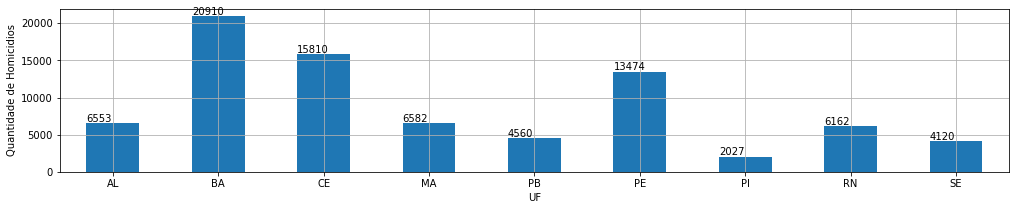

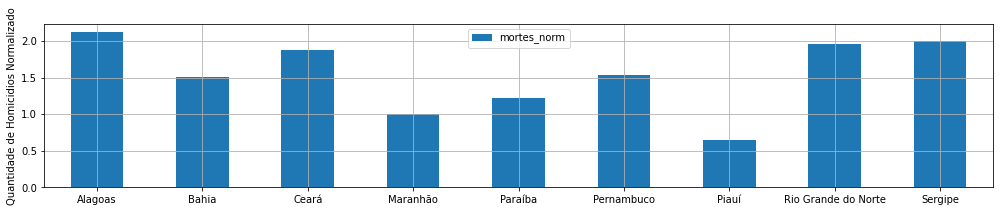

In [43]:
plot_grouped_df(sim_pf_homcidios.groupby('uf')['uf'], 
               xlabel='Quantidade de Homicidios', 
               ylabel='UF',
               figsize=(17,3))

mortes_estados_norm.plot(kind='bar',
        figsize=(17,3),
        rot=0, 
        grid=True).set_ylabel("Quantidade de Homicidios Normalizado")

In [44]:
registry_cras_rma_states_grouped['mortes'] = mortes_estados_norm['mortes_norm'].values
registry_cras_rma_states_grouped

,a1 Total de famílias em acompanhamento pelo PAIF,a2 Novas famílias inseridas no acompanhamento do PAIF no mês de referência,b1 PAIF Famílias em situação de extrema pobreza,b2 PAIF Famílias beneficiárias do Programa Bolsa Família,"b3 PAIF Famílias beneficiárias do Programa Bolsa Família, em descumprimento de condicionalidades",b5 PAIF Famílias com crianças/adolescentes em situação de trabalho infantil,b6 PAIF Famílias com crianças e adolescentes em Serviço de Acolhimento,"c1 Total de atendimentos individualizados realizados, no mês",c6 Visitas domiciliares,d1 Famílias participando regularmente de grupos no âmbito do PAIF,d4 Adolescentes de 15 a 17 anos em Serviços de Convivência e Fortalecimentos de Vínculos,mortes
uf,,,,,,,,,,,,
AL,148.745,10.990,4.108,8.961,1.784,0.353,0.667,60.314,16.971,65.843,70.980,2.119
BA,254.233,11.988,3.830,8.036,1.815,0.297,0.209,100.139,21.906,103.751,55.851,1.501
CE,133.397,4.418,1.549,3.136,0.755,0.016,0.016,96.223,27.701,44.728,52.103,1.881
MA,262.793,16.217,4.770,9.770,2.627,0.982,0.475,79.668,20.401,104.000,65.719,1.005
PB,262.493,12.072,4.753,8.184,1.538,0.287,0.206,73.090,15.413,95.265,45.807,1.218
PE,290.259,12.130,3.611,7.086,1.859,0.497,0.146,122.784,22.995,80.470,45.568,1.541
PI,234.098,15.143,7.580,9.982,4.112,0.951,0.402,116.826,15.665,135.321,49.969,0.653
RN,230.353,8.928,2.569,6.341,2.371,0.096,0.162,59.503,16.060,101.042,43.168,1.955
SE,73.053,3.987,1.520,2.827,1.267,0.040,0.093,215.000,19.400,39.973,52.520,2.005


#### (2.1) Estados com CRAS suportam moradores com dificuldade

<AxesSubplot:title={'center':'Registro de Atividades - CRAS'}, xlabel='UF', ylabel='Registros'>

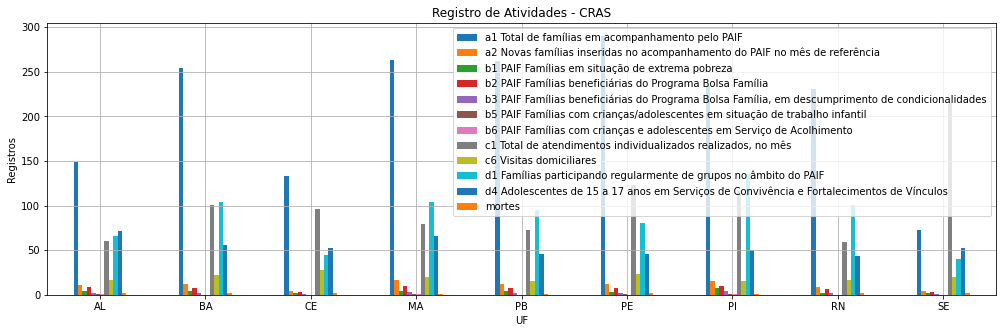

In [45]:
registry_cras_rma_states_grouped.plot(kind='bar', 
                                title='Registro de Atividades - CRAS',
                                figsize=(17,5), 
                                ylabel='Registros',
                                xlabel='UF',
                                rot=0, 
                                grid=True)

In [46]:
X = registry_cras_rma_states_grouped.iloc[:,:-1]
y = registry_cras_rma_states_grouped.iloc[:,-1:]

In [47]:
reg = LassoCV()
reg.fit(X, y)
print("Melhor valor de alpha usando LassoCV: %f" % reg.alpha_)
print("Melhor score usando LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Melhor valor de alpha usando LassoCV: 3.350955
Melhor score usando LassoCV: 0.562815


In [48]:
print("LASSO manteve " + str(sum(coef != 0)) + " variaveis, e elimina  " +  str(sum(coef == 0)) + " variaveis")

LASSO manteve 3 variaveis, e elimina  8 variaveis


Text(0.5, 1.0, 'Feature importance usando LASSO')

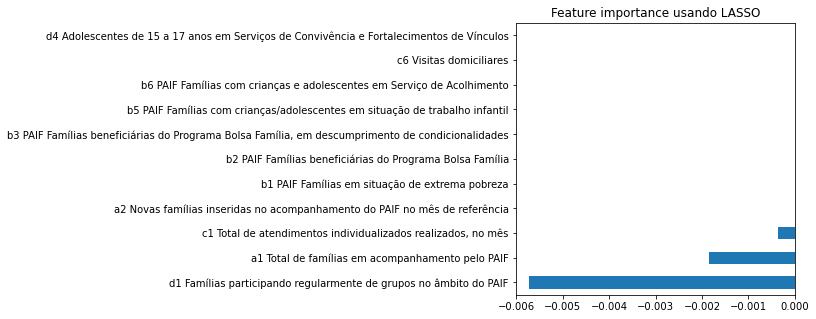

In [49]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)
imp_coef.plot(kind = "barh")
plt.title("Feature importance usando LASSO")

In [50]:
trabalhos_cras_estados_totfam = (
    registry_cras_rma_states_grouped[['a1 Total de famílias em acompanhamento pelo PAIF',
                                      'c1 Total de atendimentos individualizados realizados, no mês']]
)

trabalhos_cras_estados_extpobres = (
    registry_cras_rma_states_grouped[['b1 PAIF Famílias em situação de extrema pobreza']]
)

trabalhos_cras_estados_acompanha = (
    registry_cras_rma_states_grouped[['b5 PAIF Famílias com crianças/adolescentes em situação de trabalho infantil',
                                      'b6 PAIF Famílias com crianças e adolescentes em Serviço de Acolhimento']]
)

trabalhos_cras_estados_atendimento = (
    registry_cras_rma_states_grouped[['d1 Famílias participando regularmente de grupos no âmbito do PAIF',
                                      'd4 Adolescentes de 15 a 17 anos em Serviços de Convivência e Fortalecimentos de Vínculos']]
)

In [51]:
def plot_cras_registries(df):
    df.plot(kind='bar', 
            title='Registro de Atividades - CRAS',
            figsize=(10,5), 
            ylabel='Registros',
            xlabel='UF',
            fontsize=12,
            colormap='Pastel2',
            rot=0, 
            grid=True)

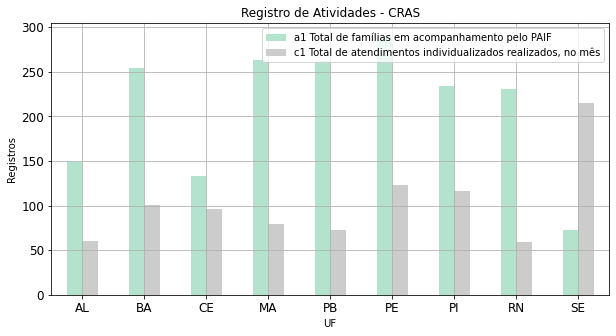

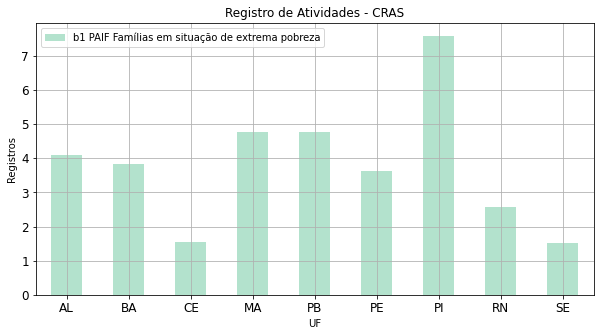

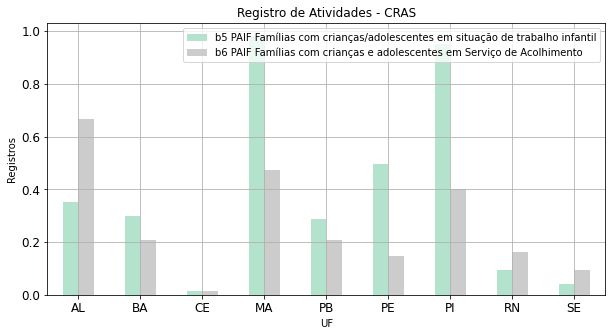

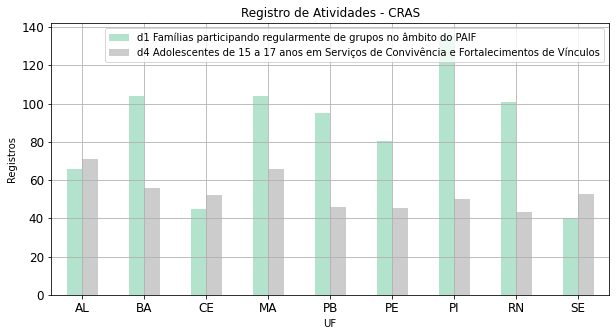

In [52]:
plot_cras_registries(trabalhos_cras_estados_totfam)
plot_cras_registries(trabalhos_cras_estados_extpobres)
plot_cras_registries(trabalhos_cras_estados_acompanha)
plot_cras_registries(trabalhos_cras_estados_atendimento)


## Recomendação

O CRAS demonstra que, se rankear-mos os estados entra os mais e menos violentos, onde ocorre maior média do índice de registros apresentado por unidades públicas CRAS, o estado tende a controlar o números de homicidios

- índices na identificação de famílias em situação de extrema pobreza
- índices na identificação de trabalho infantil e acolhimento
- índices na participação das famílias em grupos no âmbito do PAIF


---------------

#### (2.2) Estados com CRAS suportam moradores com dificuldade

In [53]:
#cras_municipios['populacao'] = list_pop
cras_rma_municipios['Mortes/Populacao'] = list_mortes_norm

In [54]:
inspect(cras_rma_municipios);

shape: (5525, 25)
columns: ['uf', 'cod_ibge', 'nome_municipio_norm', 'a1', 'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'Mortes/Populacao']


,uf,cod_ibge,nome_municipio_norm,a1,a2,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,d7,Mortes/Populacao
0,AC,120001,ACRELANDIA,39,1,0,1,0,0,0,0,32,1,1,0,0,20,0,6,33,0,35,40,1,NaN
1,AC,120005,ASSIS BRASIL,50,5,3,4,3,2,0,0,26,3,10,1,1,13,20,10,20,9,19,17,1,NaN
2,AC,120010,BRASILEIA,761,3,0,3,0,0,0,0,61,6,5,0,1,27,132,21,33,28,52,43,1,NaN
3,AC,120013,BUJARI,1,0,0,0,0,0,0,0,10,0,0,0,0,4,0,3,37,10,19,30,0,NaN
4,AC,120017,CAPIXABA,333,15,8,14,0,3,1,0,232,9,38,2,0,169,333,13,101,63,51,107,18,NaN


In [55]:
cras_rma_municipios = cras_rma_municipios.dropna()

In [56]:
cras_rma_municipios_mortes = (
    cras_rma_municipios[['uf', 
                         'nome_municipio_norm', 
                         'a1', 'a2', 
                         'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 
                         'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 
                         'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 
                         'Mortes/Populacao']]
    .reset_index(drop=True)
)

In [57]:
inspect(cras_rma_municipios_mortes);

shape: (612, 24)
columns: ['uf', 'nome_municipio_norm', 'a1', 'a2', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'Mortes/Populacao']


,uf,nome_municipio_norm,a1,a2,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,d7,Mortes/Populacao
0,AL,ARAPIRACA,59,11,2,5,0,2,0,0,237,7,47,1,0,47,10,71,71,34,31,50,2,28.091
1,AL,BATALHA,271,19,14,7,2,2,0,7,30,6,3,2,2,16,0,22,161,46,52,14,4,8.227
2,AL,CARNEIROS,204,5,0,4,2,0,0,0,14,0,1,1,0,6,101,0,122,79,70,57,2,4.405
3,AL,COITE DO NOIA,3,0,0,0,0,0,0,0,19,0,0,0,0,18,0,18,109,70,76,100,1,8.417
4,AL,FEIRA GRANDE,800,25,0,15,0,20,3,0,230,57,45,7,5,16,221,13,50,96,56,83,5,9.925


In [58]:
corr = cras_rma_municipios_mortes.corr()
corr.style.background_gradient(cmap='hot')

,a1,a2,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,d1,d2,d3,d4,d5,d6,d7,Mortes/Populacao
a1,1.000000,0.261696,0.130323,0.237616,0.107639,0.120623,0.176424,0.156095,0.049436,0.037633,-0.007722,0.114095,0.186910,0.024279,0.397989,0.156419,0.124870,0.171350,0.168773,0.136586,0.089344,0.017141
a2,0.261696,1.000000,0.692278,0.894924,0.708198,0.679032,0.524243,0.379246,0.048114,0.296261,0.068044,0.418455,0.412088,0.122664,0.201163,0.081338,0.095160,0.218095,0.142637,0.042022,0.209294,-0.011356
b1,0.130323,0.692278,1.000000,0.668265,0.591252,0.685828,0.433050,0.236270,0.040121,0.238269,0.062083,0.281069,0.217298,0.110335,0.083069,0.086154,0.093333,0.185665,0.083793,0.059388,0.179179,-0.022008
b2,0.237616,0.894924,0.668265,1.000000,0.772374,0.524085,0.332659,0.159615,0.034451,0.198281,0.057107,0.266925,0.339391,0.098250,0.190578,0.106407,0.134018,0.243150,0.162778,0.057680,0.123418,0.014921
b3,0.107639,0.708198,0.591252,0.772374,1.000000,0.506398,0.354612,0.188697,0.035181,0.163945,0.057374,0.233072,0.235773,0.046645,0.049789,0.036108,0.050396,0.175270,0.077430,-0.010503,0.123361,-0.011478
b4,0.120623,0.679032,0.685828,0.524085,0.506398,1.000000,0.639826,0.336409,0.023795,0.274013,0.023864,0.512768,0.247903,0.087964,0.082973,0.076204,0.043033,0.156094,0.081284,0.034391,0.274628,-0.047413
b5,0.176424,0.524243,0.433050,0.332659,0.354612,0.639826,1.000000,0.131178,0.017555,0.202569,0.023521,0.320388,0.130511,0.051935,0.064967,0.041685,-0.005977,0.067762,0.033944,0.008034,0.122130,-0.048012
b6,0.156095,0.379246,0.236270,0.159615,0.188697,0.336409,0.131178,1.000000,0.019856,0.203067,0.001810,0.359663,0.398422,0.074384,0.087103,0.010951,-0.009930,0.104110,0.041908,0.017987,0.271519,-0.034906
c1,0.049436,0.048114,0.040121,0.034451,0.035181,0.023795,0.017555,0.019856,1.000000,0.598761,0.756408,0.179946,0.190640,0.326161,0.061124,-0.014034,0.033366,0.034978,0.075525,0.243021,0.104637,0.149884
c2,0.037633,0.296261,0.238269,0.198281,0.163945,0.274013,0.202569,0.203067,0.598761,1.000000,0.592517,0.271781,0.216175,0.227206,0.127815,-0.024700,0.075046,0.131145,0.074243,0.100801,0.168951,0.043451


### Não é possível identificar, através de correlação, que alguma ação registrada pelo CRAS tem influência nos níveis de violência das cidades

In [59]:
cor_target = abs(corr["Mortes/Populacao"])
relevant_features = cor_target[cor_target>=0.07]

In [60]:
relevant_features

c1                 0.150
c4                 0.087
c6                 0.078
d1                 0.082
d2                 0.092
d7                 0.076
Mortes/Populacao   1.000
Name: Mortes/Populacao, dtype: float64

In [61]:
X = cras_rma_municipios_mortes.drop(['uf','nome_municipio_norm','Mortes/Populacao'],1)
y = cras_rma_municipios_mortes['Mortes/Populacao']

In [62]:
reg = LassoCV()
reg.fit(X, y)
print("Melhor valor de alpha usando LassoCV: %f" % reg.alpha_)
print("Melhor score usando LassoCV: %f" % reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Melhor valor de alpha usando LassoCV: 10.928281
Melhor score usando LassoCV: 0.057438


In [63]:
print("LASSO manteve " + str(sum(coef != 0)) + " variaveis, e elimina  " +  str(sum(coef == 0)) + " variaveis")

LASSO manteve 7 variaveis, e elimina  14 variaveis


Text(0.5, 1.0, 'Feature importance usando LASSO')

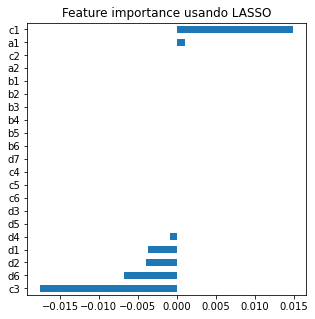

In [64]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (5, 5)
imp_coef.plot(kind = "barh")
plt.title("Feature importance usando LASSO")

In [65]:
cras_municipios_feat_select = cras_rma_municipios_mortes[['uf', 'nome_municipio_norm', 'Mortes/Populacao', 'c1', 'c3', 'd6']].reset_index(drop=True)

In [66]:
corr = cras_municipios_feat_select.sort_values(by='Mortes/Populacao', ascending=False).corr()
corr.style.background_gradient(cmap='hot')

,Mortes/Populacao,c1,c3,d6
Mortes/Populacao,1.000000,0.149884,0.024429,-0.063472
c1,0.149884,1.000000,0.756408,0.243021
c3,0.024429,0.756408,1.000000,0.096369
d6,-0.063472,0.243021,0.096369,1.000000


## Recomendação

Não é possível recomendar uma ação do CRAS a nível municipal até este instante.